# Comparison of calculated CS for deactivated and inactivated states


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy 
import os
import re
import MDAnalysis
import nmrglue as ng
%matplotlib inline

In [4]:
# read deaactivate data
#data paht:/scripts/QM_analysis/KcsA_Deactivated_df_MMQM_CS_torsion.csv
deactivate_data_path = '/Users/yunyao_1/Dropbox/KcsA/scripts/QM_analysis/KcsA_Deactivated_df_MMQM_CS_torsion.csv'
# inactivated data path: 'scripts/QM_analysis/KcsA_Inactivated_df_MMQM_CS_torsion.csv'
# no index column in the csv files
deactivate_data = pd.read_csv(deactivate_data_path)
# read inactivated data
inactivated_data_path = '/Users/yunyao_1/Dropbox/KcsA/scripts/QM_analysis/KcsA_Inactivated_df_MMQM_CS_torsion.csv'
inactivated_data = pd.read_csv(inactivated_data_path)


In [5]:
# check data so that the data is read correctly
print(deactivate_data['resNO'].unique())
print(inactivated_data['resNO'].unique())
# check the data types
print(deactivate_data.head())

[ 50  51  52  53  54  55  56  57  58  59  60 153 154 155 156 157 158 159
 160 161 162 163 256 257 258 259 260 261 262 263 264 265 266 359 360 361
 362 363 364 365 366 367 368 369]
[ 46  47  48  49  50  51  52  53  54  55  56 142 143 144 145 146 147 148
 149 150 151 152 238 239 240 241 242 243 244 245 246 247 248 334 335 336
 337 338 339 340 341 342 343 344]
   resNO atom resNam      iso    delta    ita    alpha    betta    gamma  \
0     50    C    GLU  176.730   81.275  0.949   15.152  -68.205   92.262   
1     51    N    THR  114.821  107.043  0.126   19.136  172.946  186.454   
2     51    H    THR    5.738    5.697  0.434   21.765   29.074   31.548   
3     51   CA    THR   72.823  -23.743  0.142  103.419  106.794  140.720   
4     51   HA    THR    3.922    1.965  0.436   27.313   29.831   30.688   

   frame  residue  torsion_angle_phi  torsion_angle_psi  
0      0       50         -74.405837         -20.829519  
1      0       51         -76.592973         -36.245146  
2      0 

In [6]:
# seperate the deactivate data into two parts, one for flip, ome for no flip
# flip state: torson angle of V76 > - 25
# add a new column to indicate the flip state
# only the index for V76 and G77 will be assinged with flip state
import numpy as np

# Define indices for V76
V76_index = [76 - 22 + n * 103 + 1 for n in range(4)]

# Assign flip state for V76
deactivate_data['flip_state'] = 0  # Initialize flip_state column with 0
deactivate_data.loc[
    deactivate_data['resNO'].isin(V76_index), 'flip_state'
] = np.where(
    deactivate_data.loc[deactivate_data['resNO'].isin(V76_index), 'torsion_angle_psi'] > 0,
    1, 
    0
)

G77_index = [77 - 22 + n * 103 + 1 for n in range(4)]

# Assign flip state for G77 (same as the previous residue)
# Iterate through each frame in the dataset
# Iterate through each frame in the dataset
for frame_number in deactivate_data['frame'].unique():
    # Filter data for the current frame
    frame_data = deactivate_data[deactivate_data['frame'] == frame_number]
    
    # Indices for G77 in the current frame
    G77_index = [77 - 22 + n * 103 + 1 for n in range(4)]
    
    for idx in G77_index:
        # Check if both the current and previous residues exist in the current frame
        current_res_exists = idx in frame_data['resNO'].values
        previous_res_exists = (idx - 1) in frame_data['resNO'].values
        
        if not previous_res_exists:
            print(f"Warning: Residue {idx - 1} not found in frame {frame_number}. Skipping {idx}.")
            continue
        
        if not current_res_exists:
            print(f"Warning: Residue {idx} not found in frame {frame_number}.")
            continue
        
        # Extract the flip state of the previous residue
        previous_flip_state = frame_data.loc[
            frame_data['resNO'] == idx - 1, 'flip_state'
        ].values
        
        # Check if the previous residue has a valid flip state
        if len(previous_flip_state) == 0:
            print(f"Warning: No flip_state found for residue {idx - 1} in frame {frame_number}. Skipping {idx}.")
            continue
        
        # Assign the flip state to the current residue
        deactivate_data.loc[
            (deactivate_data['frame'] == frame_number) & 
            (deactivate_data['resNO'] == idx), 
            'flip_state'
        ] = previous_flip_state[0]  # Use the first value if there's only one



# Verify results for G77 residues
#print(deactivate_data.loc[deactivate_data['resNO'].isin(G77_index), ['resNO', 'torsion_angle_psi', 'flip_state']])







In [7]:
# Filter the two datasets based on the given conditions
filter1 = deactivate_data[
    (deactivate_data['resNO'].isin(G77_index)) &
    (deactivate_data['atom'] == 'C') &
    (deactivate_data['flip_state'] == 1)
]

filter2 = deactivate_data[
    (deactivate_data['resNO'].isin(V76_index)) &
    (deactivate_data['atom'] == 'C') &
    (deactivate_data['flip_state'] == 1)
]

# Extract the unique frames from both filters
frames1 = set(filter1['frame'].unique())
frames2 = set(filter2['frame'].unique())

# Find the frames that do not match
frames_only_in_filter1 = frames1 - frames2
frames_only_in_filter2 = frames2 - frames1

# Display mismatched frames
print("Frames only in filter1 (G77_index):", frames_only_in_filter1)
print("Frames only in filter2 (V76_index):", frames_only_in_filter2)

# Optional: Display the full rows of mismatched frames
mismatched_rows_filter1 = filter1[filter1['frame'].isin(frames_only_in_filter1)]
mismatched_rows_filter2 = filter2[filter2['frame'].isin(frames_only_in_filter2)]

print("\nMismatched rows in filter1 (G77_index):\n", mismatched_rows_filter1)
print("\nMismatched rows in filter2 (V76_index):\n", mismatched_rows_filter2)



Frames only in filter1 (G77_index): {470}
Frames only in filter2 (V76_index): set()

Mismatched rows in filter1 (G77_index):
        resNO atom resNam      iso   delta    ita   alpha  betta   gamma  \
21995    159    C    GLY  175.118 -81.034  0.987  14.169 -65.84  95.716   

       frame  residue  torsion_angle_phi  torsion_angle_psi  flip_state  
21995    470      159         -83.931434         130.458876           1  

Mismatched rows in filter2 (V76_index):
 Empty DataFrame
Columns: [resNO, atom, resNam, iso, delta, ita, alpha, betta, gamma, frame, residue, torsion_angle_phi, torsion_angle_psi, flip_state]
Index: []


In [8]:
print(V76_index)
deactivate_data.loc[(deactivate_data['resNO']==158)&(deactivate_data['frame']==470)]

# V76 IN frame 470 don't have CO, that's why one mismatch between the two filters.

[55, 158, 261, 364]


,resNO,atom,resNam,iso,delta,ita,alpha,betta,gamma,frame,residue,torsion_angle_phi,torsion_angle_psi,flip_state
21981,158,N,VAL,109.631,99.730,0.090,31.639,176.735,185.735,470,158,-137.207632,87.809896,1
21982,158,H,VAL,7.238,8.656,0.402,17.306,28.548,32.031,470,158,-137.207632,87.809896,1
21983,158,CA,VAL,59.096,26.286,0.485,104.418,137.472,150.222,470,158,-137.207632,87.809896,1
21984,158,HA,VAL,4.498,-3.610,0.965,25.156,28.639,32.312,470,158,-137.207632,87.809896,1
21985,158,CB,VAL,35.424,-14.584,0.894,140.567,153.600,168.960,470,158,-137.207632,87.809896,1
21986,158,HB,VAL,1.681,-4.930,0.634,27.491,30.618,36.449,470,158,-137.207632,87.809896,1
21987,158,CG1,VAL,19.694,-17.946,0.621,155.561,166.704,188.052,470,158,-137.207632,87.809896,1
21988,158,HG11,VAL,0.383,-5.415,0.564,28.582,31.638,38.232,470,158,-137.207632,87.809896,1
21989,158,HG12,VAL,1.605,-7.830,0.509,25.688,29.672,39.425,470,158,-137.207632,87.809896,1
21990,158,HG13,VAL,1.857,-3.706,0.338,28.865,30.116,35.049,470,158,-137.207632,87.809896,1


In [9]:
#extract V76 and G77 for Deactivated state
import matplotlib.pyplot as plt

# Define indices for residues
G77_index = [77 - 22 + n * 103 + 1 for n in range(4)]
V76_index = [76 - 22 + n * 103 + 1 for n in range(4)]

# Filter rows for V76 and exclude rows where 'atom' starts with 'H'
V76_df_de = deactivate_data[
    deactivate_data['resNO'].isin(V76_index) & 
    (~deactivate_data['atom'].astype(str).str.startswith('H'))
].copy()

# Filter rows for G77 and exclude rows where 'atom' starts with 'H'
G77_df_de = deactivate_data[
    deactivate_data['resNO'].isin(G77_index) & 
    (~deactivate_data['atom'].astype(str).str.startswith('H'))
].copy()


In [10]:

# we have to remove the frame 470 in G77_df_de because V76 in frame 470 don't have CO, so we have to remove the frame 470 in G77_df_de
# Remove the specific frame from G77_df_de
G77_df_de = G77_df_de[~((G77_df_de['resNO'] == 159) & (G77_df_de['frame'] == 470))]


#check the data with flip state == 0 or 1
V76_df_de[(V76_df_de['atom'] == 'C')&(V76_df_de['flip_state'] == 1)].shape
#check the data size for G77
G77_df_de[(G77_df_de['atom'] == 'C')&(G77_df_de['flip_state'] == 1)].shape

#NOW both V76 and G77 have the same number of frames with flip state == 1

(141, 14)

In [11]:
# load the data for the inactivated state
V76_index = [76 - 26 + n * 96 + 1 for n in range(4)]
G77_index = [77 - 26 + n * 96 + 1 for n in range(4)]
# Filter rows for V76 and exclude rows where 'atom' starts with 'H'
V76_df_in = inactivated_data[
    inactivated_data['resNO'].isin(V76_index) & 
    (~inactivated_data['atom'].astype(str).str.startswith('H'))
].copy()
# Filter rows for G77 and exclude rows where 'atom' starts with 'H'
G77_df_in = inactivated_data[
    inactivated_data['resNO'].isin(G77_index) & 
    (~inactivated_data['atom'].astype(str).str.startswith('H'))
].copy()

/Users/yunyao_1/miniforge3/envs/KcsA_torsion/lib/python3.8/site-packages/MDAnalysis/analysis/base.py:438: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[i] = ts.time


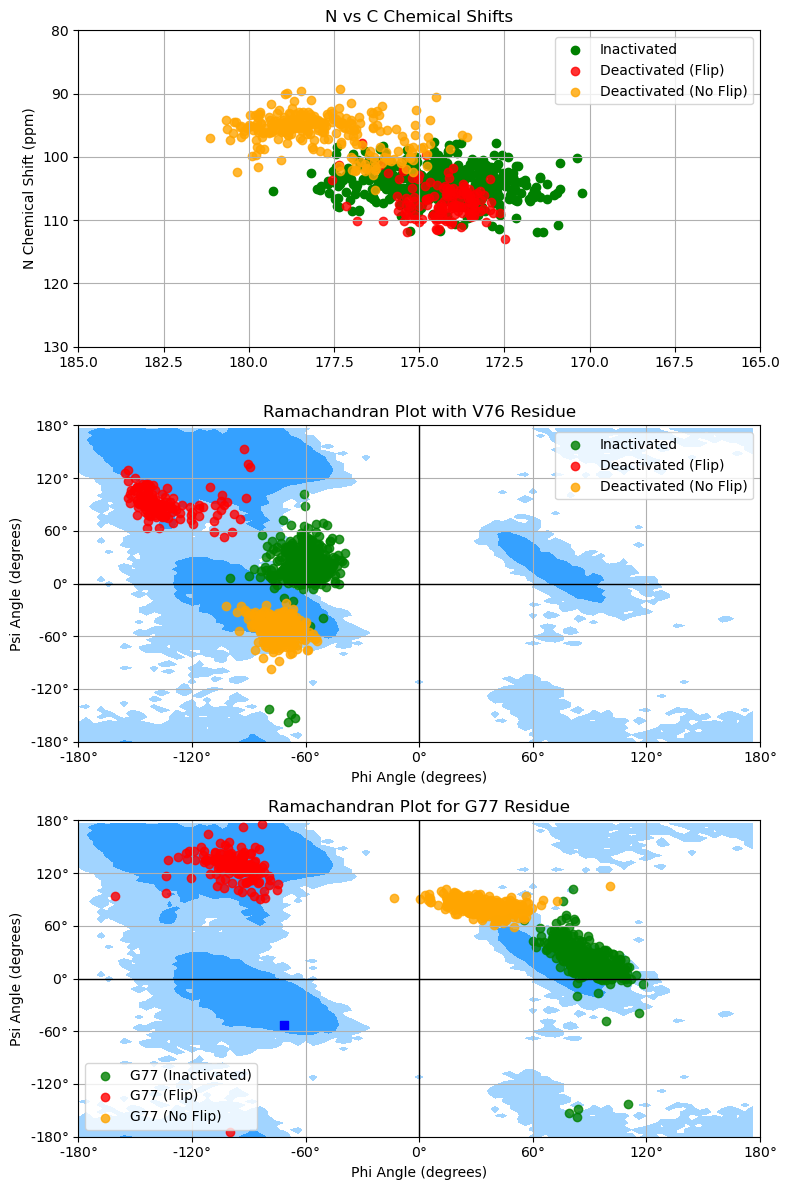

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Ramachandran

# Load torsion angle data
phi_de = np.array(V76_df_de[V76_df_de['atom'] == 'C']['torsion_angle_phi'])
psi_de = np.array(V76_df_de[V76_df_de['atom'] == 'C']['torsion_angle_psi'])

#seperate flip and no flip state
phi_v76_flip = np.array(V76_df_de[(V76_df_de['flip_state'] == 1)&(V76_df_de['atom'] == 'C')]['torsion_angle_phi'])
psi_v76_flip = np.array(V76_df_de[(V76_df_de['flip_state'] == 1)&(V76_df_de['atom'] == 'C')]['torsion_angle_psi'])
phi_v76_norm= np.array(V76_df_de[(V76_df_de['flip_state'] == 0)&(V76_df_de['atom'] == 'N')]['torsion_angle_phi'])
psi_v76_norm = np.array(V76_df_de[(V76_df_de['flip_state'] == 0)&(V76_df_de['atom'] == 'N')]['torsion_angle_psi'])

# prepare phi and psi for flip and norm for g77
phi_g77_flip = np.array(G77_df_de[(G77_df_de['flip_state'] == 1)&(G77_df_de['atom'] == 'C')]['torsion_angle_phi'])
psi_g77_flip = np.array(G77_df_de[(G77_df_de['flip_state'] == 1)&(G77_df_de['atom'] == 'C')]['torsion_angle_psi'])
phi_g77_norm = np.array(G77_df_de[(G77_df_de['flip_state'] == 0)&(G77_df_de['atom'] == 'C')]['torsion_angle_phi'])
psi_g77_norm = np.array(G77_df_de[(G77_df_de['flip_state'] == 0)&(G77_df_de['atom'] == 'C')]['torsion_angle_psi'])

phi_v76_in = np.array(V76_df_in[V76_df_in['atom'] == 'C']['torsion_angle_phi'])
psi_v76_in = np.array(V76_df_in[V76_df_in['atom'] == 'C']['torsion_angle_psi'])
#prepare phi and psi for inactivated state for g77
phi_g77_in = np.array(G77_df_in[G77_df_in['atom'] == 'C']['torsion_angle_phi'])
psi_g77_in = np.array(G77_df_in[G77_df_in['atom'] == 'C']['torsion_angle_psi'])

# Load Ramachandran data
u = mda.Universe('/Users/yunyao_1/Dropbox/KcsA/KcsA_Mutants_pdb/1K4C.pdb')
r = u.select_atoms("resid 76")
ramachandran = Ramachandran(r).run()

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Subplot 1: N vs C Chemical Shifts
CO_de = np.array(V76_df_de[(V76_df_de['atom'] == 'C')]['iso'])
N_de = np.array(G77_df_de[(G77_df_de['atom'] == 'N')]['iso'])

# spereate the flip and no flip state
CO_v76_flip = np.array(V76_df_de[(V76_df_de['flip_state'] == 1) & (V76_df_de['atom'] == 'C')]['iso'])
N_g77_flip = np.array(G77_df_de[(G77_df_de['flip_state'] == 1) & (G77_df_de['atom'] == 'N')]['iso'])
CO_v76_norm = np.array(V76_df_de[(V76_df_de['flip_state'] == 0) & (V76_df_de['atom'] == 'C')]['iso'])
N_g77_norm = np.array(G77_df_de[(G77_df_de['flip_state'] == 0) & (G77_df_de['atom'] == 'N')]['iso'])

CO_v76_in = np.array(V76_df_in[V76_df_in['atom'] == 'C']['iso'])
N_g77_in = np.array(G77_df_in[G77_df_in['atom'] == 'N']['iso'])

#axs[0].scatter(CO_de, N_de, color='red', label='Deactivated')
axs[0].scatter(CO_v76_in, N_g77_in, color='green', label='Inactivated')
axs[0].scatter(CO_v76_flip, N_g77_flip, color='red', label='Deactivated (Flip)', alpha=0.8)
axs[0].scatter(CO_v76_norm, N_g77_norm, color='orange', label='Deactivated (No Flip)', alpha=0.8)
axs[0].set_ylabel('N Chemical Shift (ppm)')
axs[0].set_title('N vs C Chemical Shifts')
axs[0].set_xlim(185, 165)
axs[0].set_ylim(130, 80)
axs[0].legend()
axs[0].grid(True)

# Subplot 2: Ramachandran Plot with Torsion Angles
ramachandran.plot(ax=axs[1], color='b', marker='s', ref=True)
# axs[1].scatter(phi_de, psi_de, color='red', label='Deactivated', alpha=0.8)
axs[1].scatter(phi_v76_in, psi_g77_in, color='green', label='Inactivated', alpha=0.8)
axs[1].scatter(phi_v76_flip, psi_v76_flip, color='red', label='Deactivated (Flip)', alpha=0.8)
axs[1].scatter(phi_v76_norm, psi_v76_norm, color='orange', label='Deactivated (No Flip)', alpha=0.8)
axs[1].set_xlabel('Phi Angle (degrees)')
axs[1].set_ylabel('Psi Angle (degrees)')
axs[1].set_title('Ramachandran Plot with V76 Residue')
axs[1].legend()
axs[1].grid(True)

# subplot 3: ramachandran plot for G77
ramachandran.plot(ax=axs[2], color='b', marker='s', ref=True)
axs[2].scatter(phi_g77_in, psi_g77_in, color='green', label='G77 (Inactivated)', alpha=0.8)
axs[2].scatter(phi_g77_flip, psi_g77_flip, color='red', label='G77 (Flip)', alpha=0.8)
axs[2].scatter(phi_g77_norm, psi_g77_norm, color='orange', label='G77 (No Flip)', alpha=0.8)
axs[2].set_xlabel('Phi Angle (degrees)')        
axs[2].set_ylabel('Psi Angle (degrees)')
axs[2].set_title('Ramachandran Plot for G77 Residue')
axs[2].legend()
axs[2].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('/Users/yunyao_1/Dropbox/KcsA/scripts/QM_analysis/KcsA_Deactivated_Inactivated_Ramachandran_Chemical_Shift.png', dpi=300, bbox_inches='tight')


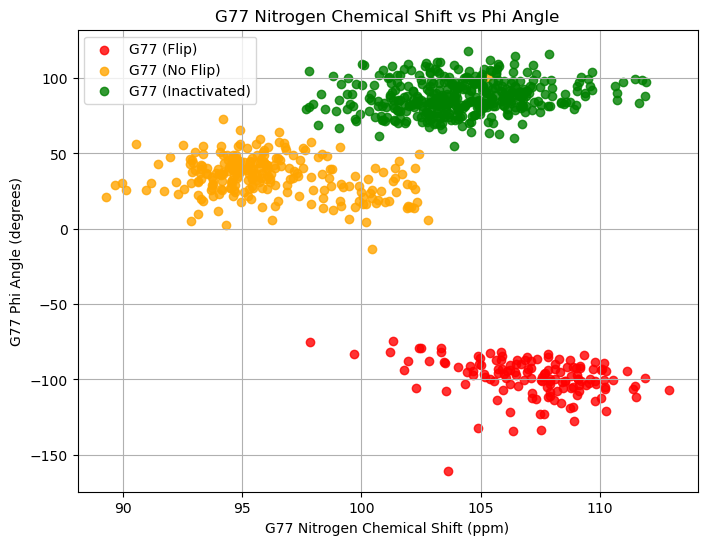

In [49]:
# plot the relation ship between g77 nitronge chemical shift and G77 phi angle

N_g77_norm = np.array(G77_df_de[(G77_df_de['flip_state'] == 0) & (G77_df_de['atom'] == 'N')]['iso'])
phi_g77_norm = np.array(G77_df_de[(G77_df_de['flip_state'] == 0)&(G77_df_de['atom'] == 'N')]['torsion_angle_phi'])
plt.figure(figsize=(8, 6))
plt.scatter(N_g77_flip, phi_g77_flip, color='red', label='G77 (Flip)', alpha=0.8)
plt.scatter(N_g77_norm, phi_g77_norm, color='orange', label='G77 (No Flip)', alpha=0.8)
plt.scatter(N_g77_in, phi_g77_in, color='green', label='G77 (Inactivated)', alpha=0.8)
plt.xlabel('G77 Nitrogen Chemical Shift (ppm)')
plt.ylabel('G77 Phi Angle (degrees)')
plt.title('G77 Nitrogen Chemical Shift vs Phi Angle')
plt.legend()
plt.grid(True)

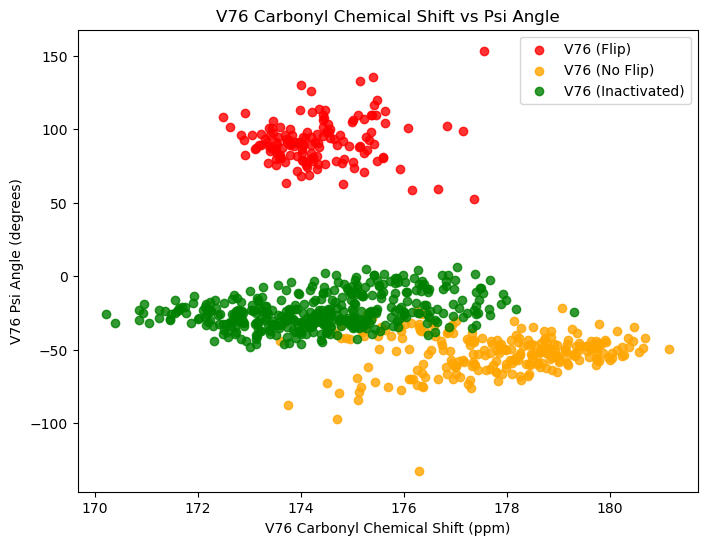

In [54]:
# plot the V76 CO chemical shift vs V76 psi angle
CO_v76_norm = np.array(V76_df_de[(V76_df_de['flip_state'] == 0) & (V76_df_de['atom'] == 'C')]['iso'])
psi_v76_norm = np.array(V76_df_de[(V76_df_de['flip_state'] == 0)&(V76_df_de['atom'] == 'C')]['torsion_angle_psi'])


plt.figure(figsize=(8, 6))
plt.scatter(CO_v76_flip, psi_v76_flip, color='red', label='V76 (Flip)', alpha=0.8)
plt.scatter(CO_v76_norm, psi_v76_norm, color='orange', label='V76 (No Flip)', alpha=0.8)
plt.scatter(CO_v76_in, psi_v76_in, color='green', label='V76 (Inactivated)', alpha=0.8)
plt.xlabel('V76 Carbonyl Chemical Shift (ppm)')
plt.ylabel('V76 Psi Angle (degrees)')
plt.title('V76 Carbonyl Chemical Shift vs Psi Angle')
plt.legend()

In [ ]:
# trouble shoting code for inbalanced number of frames

N_de_norm = np.array(G77_df_de[(G77_df_de['flip_state'] == 0) & (G77_df_de['atom'] == 'N')]['iso'])
phi_g77_norm = np.array(G77_df_de[(G77_df_de['flip_state'] == 0)&(G77_df_de['atom'] == 'N')]['torsion_angle_phi'])
print(len(N_de_norm),len(phi_g77_norm))
# trouleshoot for the difference in the number of frames
# check the frames for V76 and G77 in deactivated state
frames_V76 = V76_df_de['frame'].unique()
frames_G77 = G77_df_de['frame'].unique()
# find the frames that are not in both V76 and G77
frames_only_in_V76 = set(frames_V76) - set(frames_G77)
frames_only_in_G77 = set(frames_G77) - set(frames_V76)
print("Frames only in V76:", frames_only_in_V76)
print("Frames only in G77:", frames_only_in_G77)

# export G77_df_de to csv file

253 253
Frames only in V76: set()
Frames only in G77: set()


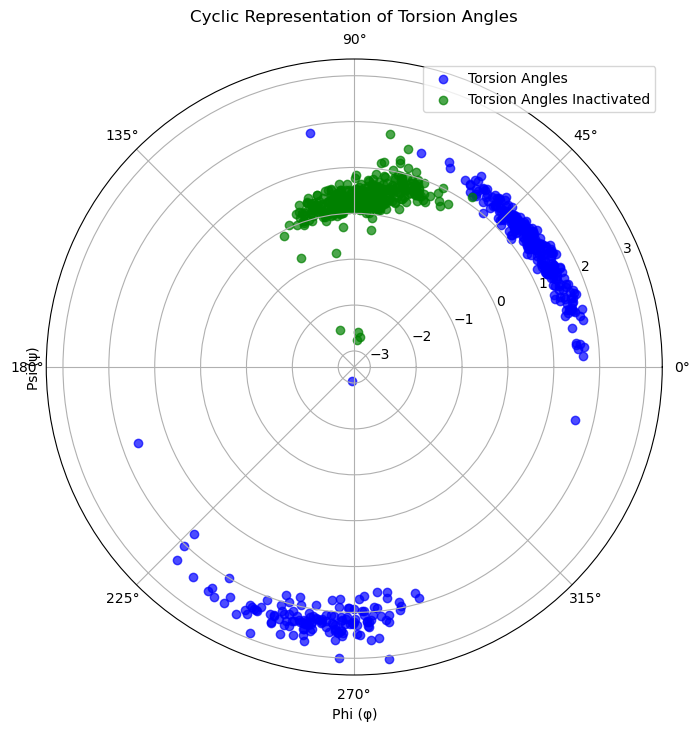

In [ ]:
# polar plot to show the cyclic representation of torsion angles
import matplotlib.pyplot as plt
import numpy as np

# Convert angles to radians for polar plotting
phi_de_radians = np.radians(phi_de)
psi_de_radians = np.radians(psi_de)

phi_in_radians = np.radians(phi_in)
psi_in_radians = np.radians(psi_in)
# Create a figure and axis for the polar plot

# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

# Scatter plot of torsion angles
ax.scatter(phi_de_radians, psi_de_radians, c='blue', alpha=0.7, label='Torsion Angles')
ax.scatter(phi_in_radians, psi_in_radians, c='green', alpha=0.7, label='Torsion Angles Inactivated')

# Add labels
ax.set_title("Cyclic Representation of Torsion Angles", va='bottom')
ax.set_xlabel("Phi (φ)")
ax.set_ylabel("Psi (ψ)")

# Show legend
ax.legend(loc="upper right")

# Show the plot
plt.show()


Text(0, 0.5, 'Intensity')

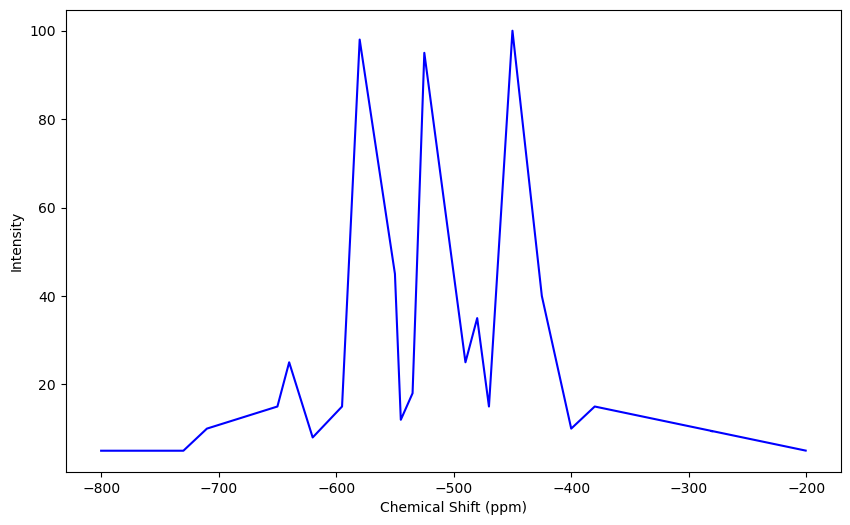

In [39]:
data = pd.read_csv('/Users/yunyao_1/Downloads/H113Cd_spectrum_extracted_test.csv', skiprows=2)
# Extract the relevant columns
x = np.array(data['Chemical Shift (ppm)'])
y = np.array(data['Intensity'])
#y1= np.array(data['Cd(benzoate)2(n-butylamine)2 (Blue)'])
# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, color='blue', label='Spectrum')
#plt.plot(x, y1, color='red', label='Spectrum 2')
plt.xlabel('Chemical Shift (ppm)')
plt.ylabel('Intensity')